In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import textstat
from collections import Counter

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
train_df = pd.read_csv("/content/train_df (1).csv", encoding="utf-8", on_bad_lines='skip').sample(4000)
test_df = pd.read_csv("/content/test_df (1).csv", encoding="utf-8", on_bad_lines='skip').sample(1000)

In [5]:
X_train = train_df["text"]
y_train = train_df["label"]
X_test = test_df["text"]
y_test = test_df["label"]

In [6]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [7]:
def extract_features(text):
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    sentences = list(doc.sents)

    features = {
        'word_count': len(words),
        'char_count': sum(len(word) for word in words),
        'sentence_count': len(sentences),
        'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
        'avg_sentence_length': len(words) / len(sentences) if sentences else 0,
        'type_token_ratio': len(set(words)) / len(words) if words else 0,
        'hapax_legomena': sum(1 for v in Counter(words).values() if v == 1) / len(words) if words else 0,
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'punctuation_count': sum(1 for token in doc if token.is_punct),
        'stopword_ratio': sum(1 for token in doc if token.is_stop) / len(words) if words else 0,
    }

    return features

In [8]:
df_features = train_df['text'].apply(extract_features).apply(pd.Series)

In [9]:
X_train = np.hstack((X_train_vec, df_features))

In [10]:
# Initialize the classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

ROC AUC Score: 0.9964
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       546
           1       0.98      0.96      0.97       454

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
 [[538   8]
 [ 18 436]]


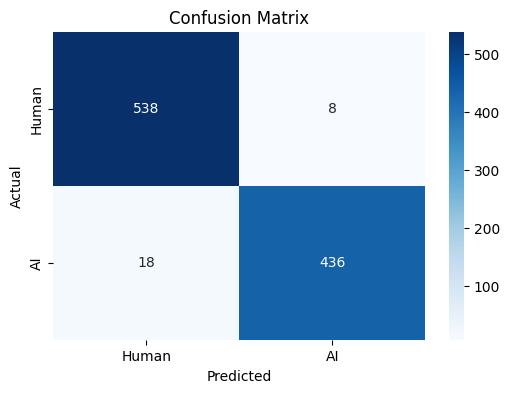

In [11]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
df_test_features = test_df['text'].apply(extract_features).apply(pd.Series)
X_test = np.hstack((X_test_vec, df_test_features))

# PredictionsX_text_tfidf
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluation
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [12]:
import shap
shap.initjs()
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
def XAI_Reasoning(new_sample):
    new_sample_tfidf = vectorizer.transform([new_sample]).toarray()

    X_additional_features = pd.DataFrame([extract_features(new_sample)])
    X = np.hstack((new_sample_tfidf, X_additional_features))
    sample_pred = xgb_clf.predict(X)
    sample_proba = sample_pred
    sample_label = (sample_pred > 0.5).astype(int)
    print(f"Predicted Label: {sample_label[0]}")
    print(f"Predicted Probability of being AI-generated: {sample_proba[0]:.4f}")

    print("SHAP Explanations:")
    sentences = sent_tokenize(new_sample)

    sentence_embeddings = np.array([vectorizer.transform([sentence]).toarray()[0] for sentence in sentences])

    additional_features = np.array([pd.DataFrame([extract_features(sentence)]).to_numpy().flatten() for sentence in sentences])


    final_features = np.hstack((sentence_embeddings, additional_features))

    explainer = shap.TreeExplainer(xgb_clf)
    shap_values = explainer.shap_values(final_features)

    abs_shap_values = np.abs(shap_values)

    sentence_impact = np.sum(abs_shap_values, axis=1)
    sentence_impact_scalar = [np.sum(impact) for impact in sentence_impact]

    sentence_impact_sorted = sorted(zip(sentence_impact_scalar, sentences, additional_features), reverse=True)
    print("Sentence Impact Ranking (Most Impactful Sentence First):")
    for impact, sentence, additional_feat in sentence_impact_sorted:
        if isinstance(impact, (np.ndarray, list)):
            impact_value = np.mean(impact)
        else:
            impact_value = float(impact)
        print(f"Impact: {impact_value:.4f} | Sentence: {sentence}")
    sentence_labels = [f"Sentence {i + 1}" for i in range(len(sentences))]
    impact_values = [np.mean(impact) if isinstance(impact, (np.ndarray, list)) else float(impact)
                     for impact, _, _ in sentence_impact_sorted]

    plt.figure(figsize=(10, 8))
    bars = plt.barh(sentence_labels, impact_values, color='skyblue')
    plt.xlabel('Impact Value')
    plt.ylabel('Sentence')
    plt.title('Sentence Impact Analysis')
    plt.gca().invert_yaxis()

    # Add impact values on bars
    for bar, value in zip(bars, impact_values):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{value:.4f}",
                 va='center', fontsize=10, color='black')

    plt.show()

Predicted Label: 1
Predicted Probability of being AI-generated: 1.0000
SHAP Explanations:
Sentence Impact Ranking (Most Impactful Sentence First):
Impact: 19.2833 | Sentence: One of the factors that make the Kuiper Belt a mystery is its origin.
Impact: 18.8497 | Sentence: It is a vast ring of icy objects that surrounds our Solar System beyond the orbit of Neptune.
Impact: 18.7045 | Sentence: Scientists are unsure of how and why these icy objects formed and how they ended up in their current positions.
Impact: 18.0653 | Sentence: However, one of the most intriguing and still unexplained astronomical phenomena is the Kuiper Belt.
Impact: 17.9980 | Sentence: The promise of uncovering the secrets of its origins and behavior continues to inspire astronomers and scientists around the world.
Impact: 17.9211 | Sentence: Furthermore, scientists are puzzled by the strange behavior of some of the objects in the Kuiper Belt, particularly those that seem to be out of place.
Impact: 17.8597 | Senten

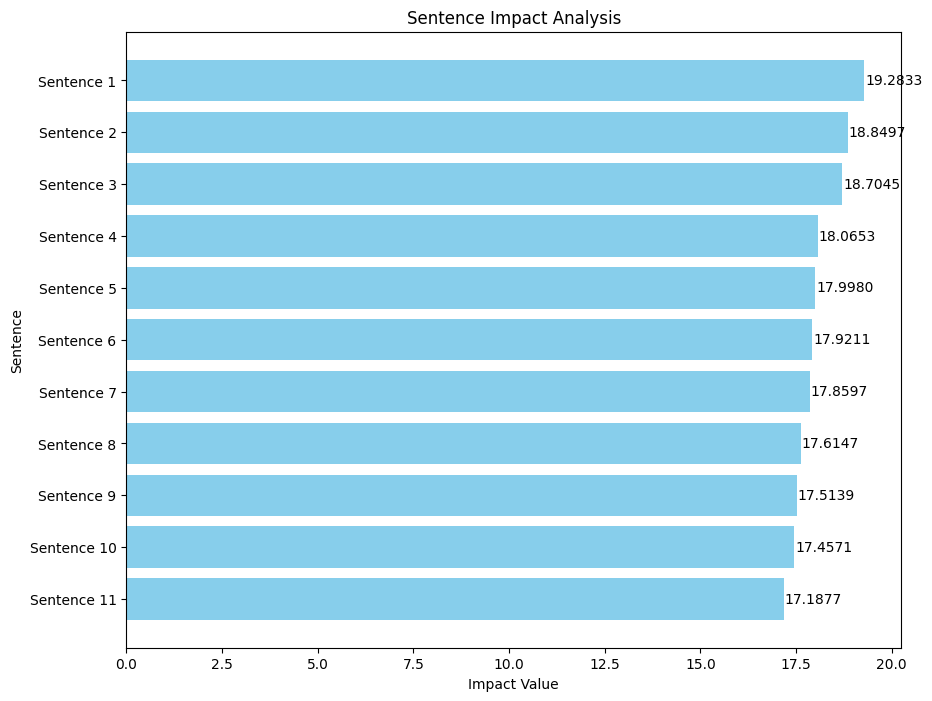

In [14]:
ai_texts = test_df[test_df['label'] == 1]['text'].sample(n=1).iloc[0]
XAI_Reasoning(ai_texts)

Predicted Label: 0
Predicted Probability of being AI-generated: 0.0000
SHAP Explanations:
Sentence Impact Ranking (Most Impactful Sentence First):
Impact: 19.9319 | Sentence: When my daughter was born she still had lots of it .
Impact: 19.9282 | Sentence: Newborn babies are wrinkly .
Impact: 19.4016 | Sentence: Edit : [ from Scientific American ] ( URL_0 ) Vernix is a waxy coating that protects the babies skin , it gets shed and swallowed by baby to form maconium as the pregnancy progresses .
Impact: 19.1136 | Sentence: Source : I am a baby nurse .
Impact: 18.5965 | Sentence: Some are more wrinkly than others , but I 've seen and washed thousands and they 've pretty much all been wrinkly at first .
Impact: 17.3242 | Sentence: Skin wrinkles in water not because it absorbs the liquid , but because tiny muscles under the skin cause the wrinkles on the hands and feet to improve grip to offset the slipperiness of the water .


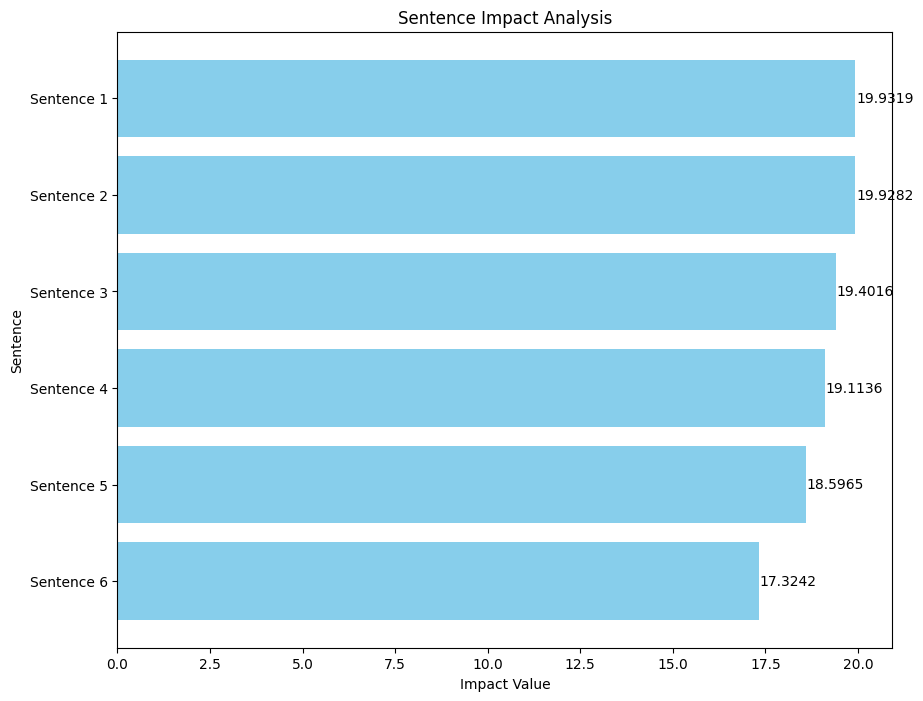

In [15]:
human_texts = test_df[test_df['label'] == 0]['text'].sample(n=1).iloc[0]
XAI_Reasoning(human_texts)

In [46]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

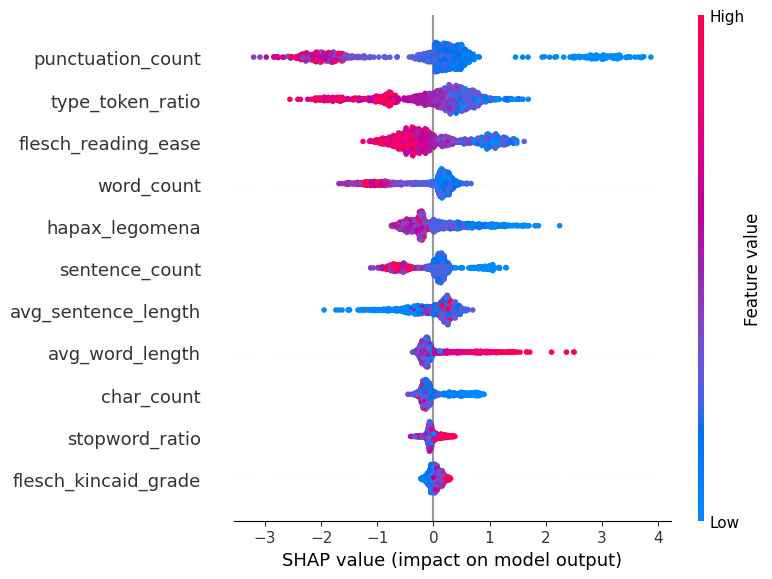

In [17]:
shap_values_features = shap_values[:, -11:]
shap.summary_plot(shap_values_features, df_test_features, feature_names=df_test_features.columns)

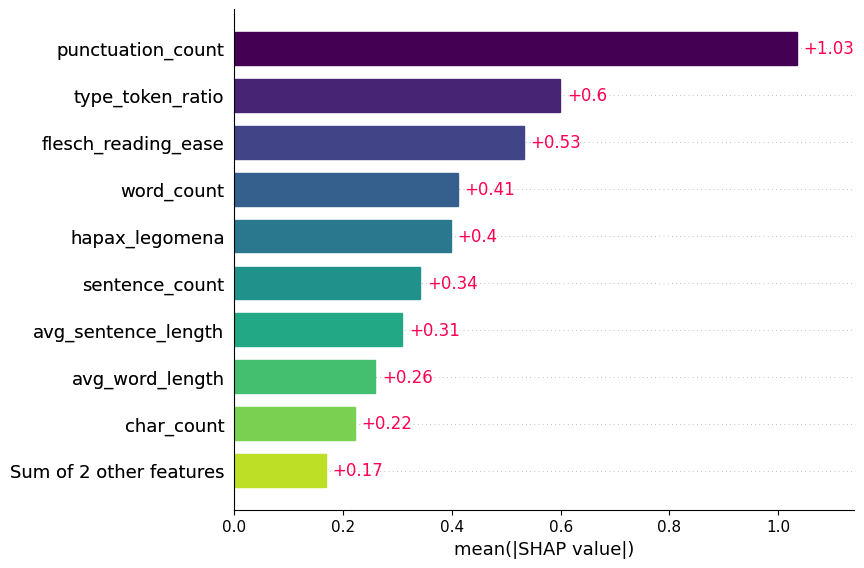

In [47]:
shap_values_exp = shap.Explanation(values=shap_values_features,
                                   feature_names=df_test_features.columns)
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_values_exp, show=False)

ax = plt.gca()
for i, bar in enumerate(ax.patches):
    bar.set_color(plt.cm.viridis(i / len(ax.patches)))  # use viridis colormap

plt.show()

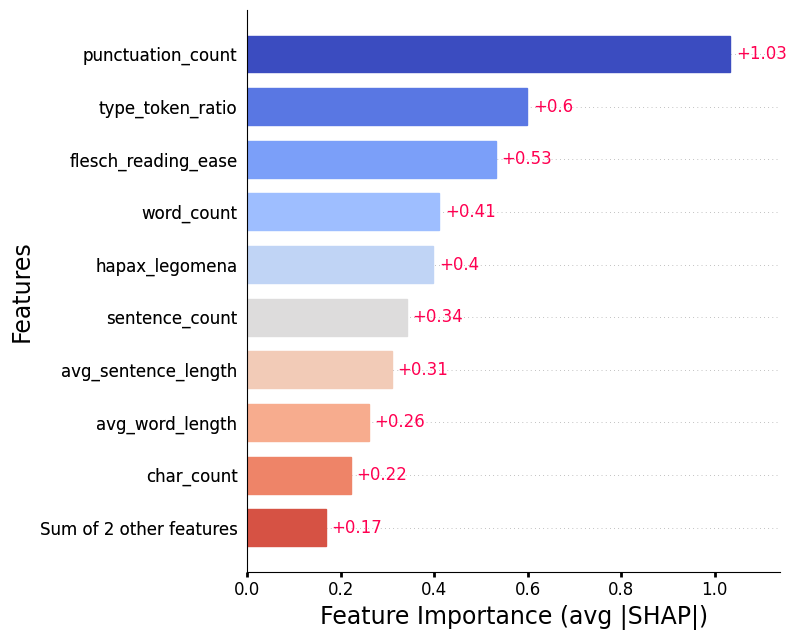

In [52]:
plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values_exp, show=False)

ax = plt.gca()

for i, bar in enumerate(ax.patches):
    bar.set_color(plt.cm.coolwarm(i / len(ax.patches)))

# Make text bold
ax.set_xlabel("Feature Importance (avg |SHAP|)", fontsize=17, fontweight="medium")
ax.set_ylabel("Features", fontsize=17, fontweight="medium")

# Bold tick labels
ax.tick_params(axis='x', labelsize=12, width=2, labelrotation=0)
ax.tick_params(axis='y', labelsize=12, width=2)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("medium")

plt.tight_layout()
plt.show()

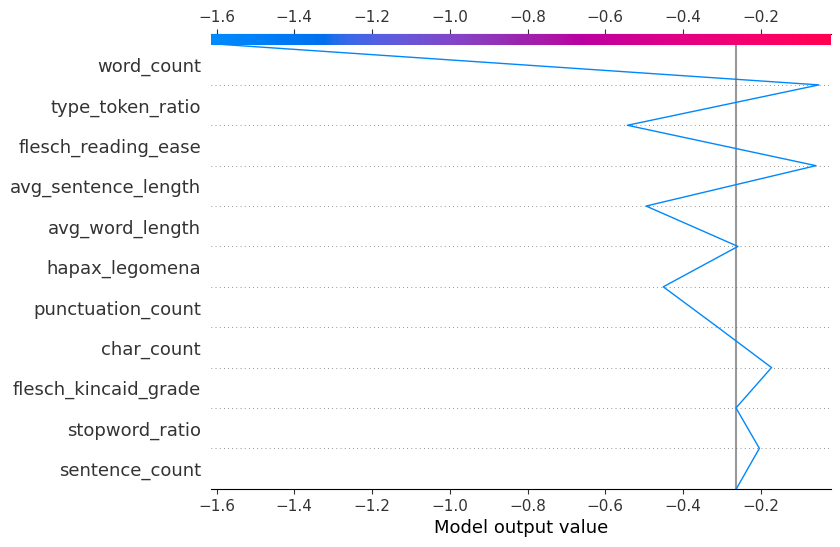

In [19]:
shap_values_array = shap_values_features.values
shap.decision_plot(explainer.expected_value, shap_values_array[0], df_test_features.columns)